Install Libraries
---

In [1]:
!pip install wavio

Config
---

In [2]:
source_file = '/kaggle/input/essex30-30s/essex30_30s_test/split_30_essex30_source.wav'
target_file = '/kaggle/input/essex30-30s/essex30_30s_test/split_30_essex30_amp_ir.wav'
test_size = 0.2
lstm_hidden_size = 64
batch_size = 16
epochs = 20
# Samples to look back for LSTM
lookback = 10

Functions
---

In [3]:
import numpy as np
import wavio

def wav_to_np(filepath: str) -> np.ndarray:
    with open(filepath, 'rb') as wave_file:
        w = wavio.read(wave_file)
        channels = w.data.shape[1]
        assert channels == 1
        samplewidth = w.sampwidth
        assert samplewidth == 3
        framerate = w.rate
        assert framerate == 48000

        frame_length = w.data.shape[0]

        print(f'Channels: {channels}')
        print(f'Frame Length: {frame_length}')
        print(f'Sample Width: {samplewidth}')
        print(f'Frame Rate {framerate}')

    return w.data

In [4]:
import matplotlib.pyplot as plt

def draw_file(data: np.array):
    plt.plot(data)
    plt.show()

Load the data
---

Channels: 1
Frame Length: 1440000
Sample Width: 3
Frame Rate 48000
Channels: 1
Frame Length: 1440000
Sample Width: 3
Frame Rate 48000
(1440000, 1)
(1440000, 1)


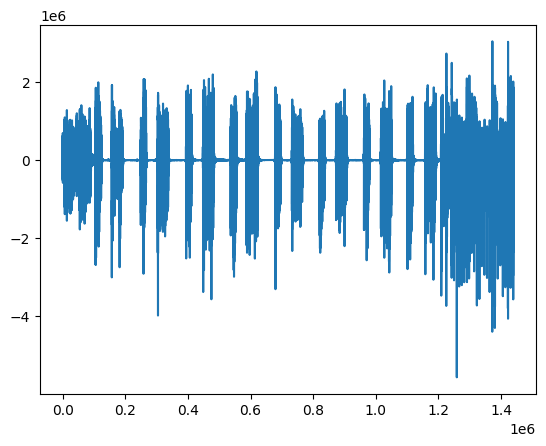

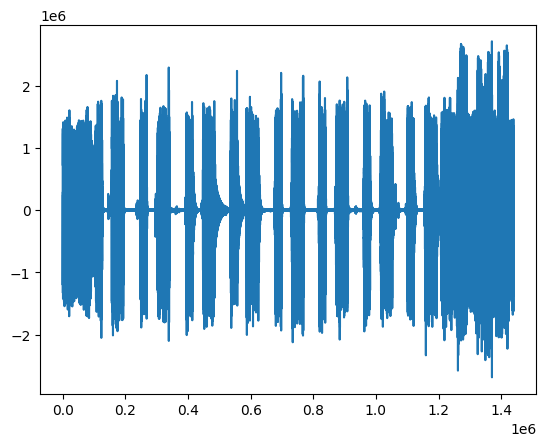

In [5]:
source = wav_to_np(source_file)
target = wav_to_np(target_file)
print(source.shape)
print(target.shape)

draw_file(source)
draw_file(target)

Preprocess Data
---

In [6]:
# Normalize between 0 and 1

from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler((0,1))
source_normalized = scalar.fit_transform(source)
target_normalized = scalar.fit_transform(target)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Split Dataset
---

In [7]:
total_size = len(source)
test_size = int(total_size * test_size)
train_size = total_size - test_size
print(train_size, test_size)

source_train = source_normalized[:train_size, :]
target_train = target_normalized[:train_size, :]

source_test = source_normalized[train_size:, :]
target_test = source_normalized[train_size:, :]

print(source_train.shape, target_train.shape)
print(source_test.shape, target_test.shape)

1152000 288000
(1152000, 1) (1152000, 1)
(288000, 1) (288000, 1)


Create the RNN dataset
---
Dataset will contain the previous 25 samples as 'lookback'


In [8]:
def create_dataset(source: np.ndarray, target: np.ndarray, lookback = 1):
    data_x, data_y = [], []
    for i in range(len(source) - lookback - 1):
        a = source[i:(i + lookback), 0]
        data_x.append(a)
        data_y.append(target[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

In [9]:
(X_train, y_train) = create_dataset(source_train, target_train, lookback)
(X_test, y_test) = create_dataset(source_test, target_test, lookback)

In [10]:
# Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1151989, 1, 10) (1151989,)
(287989, 1, 10) (287989,)


Create the Model
---

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense

tf.random.set_seed(3)

#Create a Keras Model
model = Sequential()
#Add LSTM
model.add(LSTM(lstm_hidden_size, input_shape=(1,lookback)))
model.add(Dense(1))

#Compile with Adam Optimizer. Optimize for minimum mean square error
model.compile(loss="mean_squared_error",
                 optimizer="adam",
                 metrics=["mse"])

#Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19200     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
_________________________________________________________________


Train!
---

Epoch 1/20
72000/72000 [==============================] - 294s 4ms/step - loss: 0.0058 - mse: 0.0058
Epoch 2/20
72000/72000 [==============================] - 294s 4ms/step - loss: 0.0056 - mse: 0.0056
Epoch 3/20
72000/72000 [==============================] - 296s 4ms/step - loss: 0.0056 - mse: 0.0056
Epoch 4/20
72000/72000 [==============================] - 296s 4ms/step - loss: 0.0055 - mse: 0.0055
Epoch 5/20
72000/72000 [==============================] - 296s 4ms/step - loss: 0.0055 - mse: 0.0055
Epoch 6/20
72000/72000 [==============================] - 297s 4ms/step - loss: 0.0054 - mse: 0.0054
Epoch 7/20
72000/72000 [==============================] - 302s 4ms/step - loss: 0.0054 - mse: 0.0054
Epoch 8/20
72000/72000 [==============================] - 303s 4ms/step - loss: 0.0054 - mse: 0.0054
Epoch 9/20
72000/72000 [==============================] - 300s 4ms/step - loss: 0.0054 - mse: 0.0054
Epoch 10/20
72000/72000 [==============================] - 296s 4ms/step - loss: 0.0053 - m

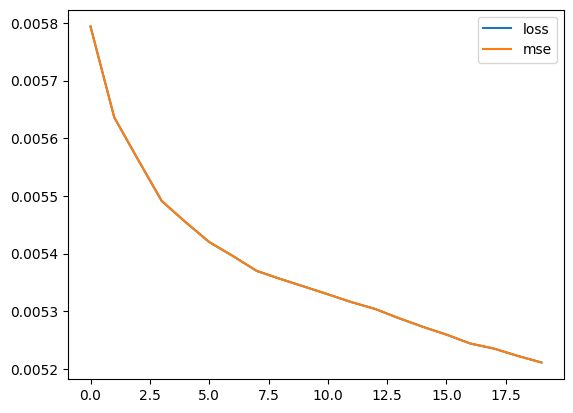

In [12]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
loss = history.history['loss']
mse = history.history['mse']
plt.plot(loss, label='loss')
plt.plot(mse, label='mse')
plt.legend()
plt.show()

Test
---

In [13]:
#Evaluate the model
result = model.evaluate(X_test, y_test, verbose=1)

#Predict on the test dataset
predictions = model.predict(X_test)

#Inverse the scaling to view results
predictions = scalar.inverse_transform(predictions)

9000/9000 [==============================] - 18s 2ms/step


Visualize Results
---

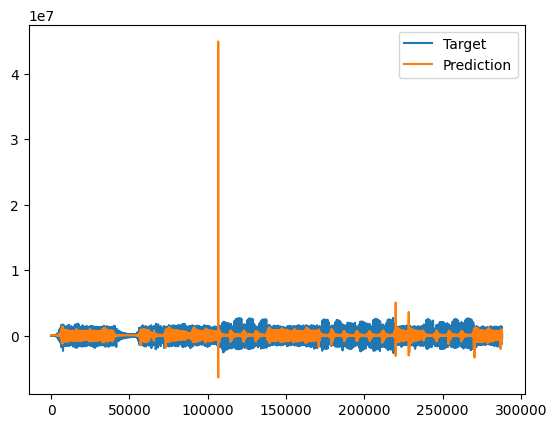

In [14]:
#TODO The data is offset by the lookback amount samples, need to figure that out.
y_target = target[train_size + lookback:]
plt.plot(y_target, label='Target')
plt.plot(predictions, label='Prediction')
plt.legend()
plt.show()